# Segundo punto

Juan Sebastian Espitia

Anamaria Irmgard Mojica 201316580

María José Ocampo 201719100

Leidy Romero Santana 201714832

### Enunciado:
Comparación de estrategias de motores de búsqueda

A continuación, implementará un motor de búsqueda con cuatro estrategias diferentes.
1. Búsqueda binaria (BS).
2. Búsqueda binaria con índice invertido (BSII)
3. Recuperación clasificada básica (RRI)
4. Recuperación clasificada y vectorización de documentos (RRDV)
Debe hacer su propia implementación utilizando numpy y pandas para manejar matrices y matrices.

Nota: Hay puntos adicionales [15p] si su implementación de "índice invertido" está distribuida (usando para
ejemplo MapReduce) o la clasificación de discos eficiente se realiza mediante BSBI. Ambas estrategias se explican en
capítulo 4 del libro https://nlp.stanford.edu/IR-book/pdf/04const.pdf.
Conjunto de datos: hay tres archivos que componen el conjunto de datos. "Docs raws texts" contiene 331 documentos en
formato NAF (XML: debe utilizar el título y el contenido para modelar cada documento). "Queries raw text" contiene
35 consultas. "relevance-judgments.tsv" contiene para cada consulta los documentos relevantes. Estos documentos relevantes fueron construidos manualmente por jueces humanos y sirven como conjunto de datos de evaluación.

Pasos de preprocesamiento: para los siguientes puntos, debe preprocesar documentos y consultas utilizando tokenización por palabra, eliminación de stop words, normalización y stemming. 

Primero se instalan los paquetes necesarios


In [ ]:
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install gensim
!pip install spacy
!pip install textblob
!pip install pyspark

# CARGA DE DATOS

In [43]:
# cargar el vocabulario
vocabulario = {}
indice_vocabulario = {}

f = open('/content/diccionario-lemmas-nltk.txt')
i = 0
for line in f.readlines():
  line=line.strip()
  vocabulario[i] = line
  indice_vocabulario[line] = i
  i+=1
f.close()

print("Se cargaron ", len(vocabulario), " palabras")

# cargar los documentos
documentos = {}
indice_documentos = {}
indice_invertido_documentos ={}

f = open('/content/docs.csv')
i = 0
for line in f.readlines():
  line=line.strip()
  id_doc = line.split(";")[0]
  palabras_doc = line.split(";")[1]
  documentos[id_doc] = set(palabras_doc.split(','))
  indice_documentos[id_doc] = i
  indice_invertido_documentos[i] = id_doc
  i+=1
f.close()

print("Se cargaron ", len(documentos), " documentos")

#cargar las queries
queries = {}

f = open('/content/queries.csv')
i = 0
for line in f.readlines():
  line=line.strip()
  id_query = line.split(";")[0]
  palabras_query = line.split(";")[1]
  queries[id_query] = palabras_query.split(',')
  i+=1
f.close()

print("Se cargaron ", len(queries), " queries")

Se cargaron  16864  palabras
Se cargaron  331  documentos
Se cargaron  35  queries


In [45]:
print(vocabulario)
print("-"*200)
print(documentos)
print("-"*200)
print(indice_documentos)
print("-"*200)
print(indice_invertido_documentos)
print("-"*200)
print(queries)

{0: 'theta', 1: 'seminary', 2: 'scout', 3: 'plumeria', 4: 'derives', 5: 'unquestionable', 6: 'admission', 7: 'action', 8: 'repeat', 9: 'moor', 10: 'verrier', 11: 'gerhard', 12: 'utah', 13: 'gogh', 14: 'moses', 15: 'stehen', 16: 'lynch', 17: 'ex', 18: 'logic', 19: 'crocodile', 20: 'exposed', 21: 'fire', 22: '1717', 23: 'imaginative', 24: 'restrained', 25: 'hope', 26: 'alfonso', 27: 'gout', 28: 'ardenne', 29: 'self', 30: 'rotbart', 31: 'nervorum', 32: 'gamely', 33: 'duwal', 34: 'provincial', 35: 'drum', 36: 'futilely', 37: 'special', 38: 'recherches', 39: 'sereno', 40: 'skreen', 41: 'tull', 42: 'anson', 43: 'valuable', 44: 'half', 45: 'originated', 46: 'simplicity', 47: 'substituted', 48: 'gouvernement', 49: 'businessmen', 50: 'executioner', 51: 'inner', 52: 'metempsychosis', 53: 'pittsburgh', 54: 'immune', 55: 'prussian', 56: 'airline', 57: 'exhibited', 58: 'store', 59: 'scurvy', 60: 'mall', 61: 'monterey', 62: 'apart', 63: 'bestseller', 64: 'harbor', 65: 'strathclyde', 66: 'end', 67: '

# ESTRATEGIA DE BUSQUEDA BINARIA (BS)
1. Cree su propia implementación de la matriz de incidencia de documentos de términos binarios utilizando los 331 documentos en el conjunto de datos. 

2. Cree una función que lea la matriz binaria y calcule consultas binarias conjuntas utilizando operaciones bit a bit. 

3. Para cada una de las 35 consultas en el conjunto de datos, recupere los documentos utilizando consultas binarias conjuntas. Escriba un archivo (BS-queries_results) con los resultados siguiendo el mismo formato que el archivo "Relevancia-juicios" 

## MATRIZ DE INCIDENCIA DE DOCUMENTOS EN TÉRMINOS BINARIOS

In [46]:
#crear matrix
matriz_incidencia = np.zeros( (len(documentos), len(vocabulario)) )

print(matriz_incidencia.shape)

(331, 16864)


In [47]:
# llenar matriz
for d in documentos:
  palabras_doc = documentos[d]
  indice_doc = indice_documentos[d]
  for p in palabras_doc:
    indice_palabra = indice_vocabulario[p]
    matriz_incidencia[indice_doc][indice_palabra]=1

print(matriz_incidencia)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [67]:
# almacenar matriz
import h5py

h5f = h5py.File('incidence matrix.h5', 'w')
h5f.create_dataset('matrix', data=matriz_incidencia)
h5f.close()

In [69]:
# cargar matriz
h5f = h5py.File('incidence matrix.h5','r')
matriz_incidencia = h5f['matrix'][:]
h5f.close()

## CONSULTAS BINARIAS CONJUNTAS

In [61]:
def consulta_binaria(consulta):
  documentos_relevantes = []
  for i in range(len(matriz_incidencia)):
    doc = matriz_incidencia[i]
    resultado_conjuncion = 0
    num_pal_query = 0
    for j in range(len(doc)):
      resultado_conjuncion += int(doc[j]) & int(consulta[j])
      num_pal_query += consulta[j]
    if resultado_conjuncion == num_pal_query:
      documentos_relevantes.append(indice_invertido_documentos[i])

  return documentos_relevantes

## DOCUMENTOS RELEVANTES 

In [65]:
f = open('BS-queries_results.tsv', 'w')
for q in queries:
  query = np.zeros(len(vocabulario))
  for palabra in queries[q]:
    if palabra in indice_vocabulario:
      query[indice_vocabulario[palabra]] = 1

  comma = ","
  docs_relevantes = consulta_binaria(query)
  print(q+'\t'+comma.join(docs_relevantes))
  f.write(q+'\t'+comma.join(docs_relevantes))

f.close()

q01	
q02	d291,d293
q03	d105,d147,d152,d283,d291,d318
q04	d286
q06	d026,d029,d069,d257,d297,d329
q07	d004
q08	d110,d251
q09	d198,d205,d223
q10	d231
q12	
q13	
q14	
q16	d132,d150,d176,d184,d229,d250,d277
q17	d121,d271
q18	d192,d203,d210
q19	d179
q22	
q23	
q24	d129,d221
q25	d020,d023,d032,d128,d156,d166,d167,d211,d245,d247,d265,d328
q26	
q27	
q28	d136,d174
q29	d037,d046,d294
q32	d025,d031,d090,d139,d254
q34	
q36	
q37	d169
q38	
q40	
q41	
q42	
q44	d029,d185
q45	d105
q46	d093,d094,d121,d133


## MÉTRICAS

In [75]:
for q in queries:
  query = np.zeros(len(vocabulario))
  antes = datetime.datetime.now()
  for palabra in queries[q]:
    if palabra in indice_vocabulario:
      query[indice_vocabulario[palabra]] = 1

  docs_relevantes = consulta_binaria(query)
  despues = datetime.datetime.now()
  print(q+'\t'+comma.join(docs_relevantes)+'\t'+str((despues-antes).seconds)+"s")


q01		4s
q02	d291,d293	4s
q03	d105,d147,d152,d283,d291,d318	4s
q04	d286	4s
q06	d026,d029,d069,d257,d297,d329	4s
q07	d004	4s
q08	d110,d251	4s
q09	d198,d205,d223	4s
q10	d231	4s
q12		4s
q13		4s
q14		4s
q16	d132,d150,d176,d184,d229,d250,d277	4s
q17	d121,d271	4s
q18	d192,d203,d210	4s
q19	d179	4s
q22		5s
q23		4s
q24	d129,d221	5s
q25	d020,d023,d032,d128,d156,d166,d167,d211,d245,d247,d265,d328	5s
q26		5s
q27		5s
q28	d136,d174	5s
q29	d037,d046,d294	5s
q32	d025,d031,d090,d139,d254	4s
q34		4s
q36		4s
q37	d169	4s
q38		4s
q40		4s
q41		4s
q42		4s
q44	d029,d185	4s
q45	d105	4s
q46	d093,d094,d121,d133	4s


# BUSQUEDA BINARIA USANDO INDICE INVERTIDO (BSII)
1. Cree su propia implementación del índice invertido utilizando los 331 documentos en el conjunto de datos. (El índice invertido debe almacenarse y leerse desde el disco.)
2. Cree una función que lea el índice invertido y calcule consultas booleanas utilizando el algoritmo de combinación. Debe modificar el algoritmo de combinación para calcular: AND, OR y NOT.
3. Para cada una de las 35 consultas en el conjunto de datos, recupere los documentos utilizando consultas binarias conjuntas. Escriba un archivo (BSII-AND-queries_results) con los resultados siguiendo el mismo formato que "juicios de relevancia" 
4. Para cada una de las 35 consultas en el conjunto de datos, recupere los documentos relevantes utilizando consultas binarias disyuntivas. Escriba un archivo (BSII-OR-queries_results) con los resultados siguiendo el mismo formato que "juicios de relevancia"  


# RECUPERACION RANQUEADA BASICA (RRI)
1. Modifique el índice invertido para almacenar el tf.
2. Cree una función que lea el índice invertido modificado y calcule la puntuación del documento para una consulta determinada utilizando: 
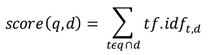
3. Para cada una de las 35 consultas del conjunto de datos, recupere los documentos clasificados -ordenados por puntuación- (incluya solo los documentos con una puntuación superior a 0 para una consulta determinada). Escriba un archivo (RRI-queries_results) con los resultados siguiendo el mismo formato que el archivo "relevance-judgments" 
4. Calcule P@M, R@M, NDCG@M por consulta. M es el número de documentos relevantes que se encuentran en el archivo de relevance-judgments por consulta. Luego calcule MAP como métrica general. 

NOTA I: Para P@M y R@M, suponga una escala de relevancia binaria. Los documentos que no se encuentran en el archivo de relevance-judgments NO son relevantes para una consulta determinada.

NOTA II: Para NDCG@M use la escala de relevancia no binaria que se encuentra en el archivo de relevance-judgments. 

# RECUPERACIÓN RANQUEADA Y VECTORIZACION DE DOCUMENTOS (RRDV)
1. 

# GENSIM Corpus y modelo Tf.Idf

# Análisis de resultados

BS vs BSII

RRI, RRDV and Gensim